In [16]:
import import_ipynb
import numpy as np
import copy
import rtree
from rtree import index

Qd-tree's greedy construction:
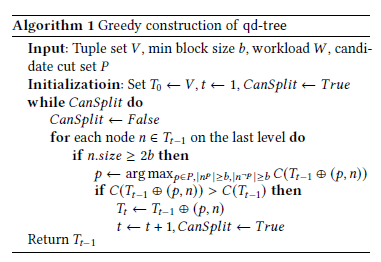

In [17]:
def skip_calculation(queries, kdnodes):
    '''
    @return: the number of tuples that can be skipped
    '''
    
    # number of dimensions
    dims = int(len(queries[0]))
    
    count_skip = 0
    
    # for each query
    for i in range(len(queries)):
        
        # check for intersection for each kdnode
        for j in range(len(kdnodes)):
            
            if kdnodes[j][1] <= 0:
                continue
            
            intersection_tag = True
            
            # for each dimension
            for k in range(dims):
                
                # an intersection holds if it intersecs in all dimensions
                if queries[i][k][0] >= kdnodes[j][0][k][1] or queries[i][k][1] <= kdnodes[j][0][k][0]:
                    intersection_tag = False
                    break
                
            # if the query intersect with this kdnode
            if not intersection_tag:
                count_skip += kdnodes[j][1]
    
    return count_skip

In [19]:
# # = = = Unit Test = = =
# tiny_query_set = [ [[1,3.5],[1,3.5]], [[3,6],[5,8]], [[7,8],[3,6]] ]
# tiny_kdnodes = [ [[[0,10],[0,4]],10], [[[0,10],[4,10]],10] ]

# tiny_skip = skip_calculation(tiny_query_set, tiny_kdnodes)
# print(tiny_skip) # should be 20

20


In [2]:
# try to improve the speed calculation with indexing
def skip_calculation_optimized(queries, kdnodes, TOTAL_SIZE, idx):
    '''
    @parameter: idx: the Rtree index
    @return: the number of tuples that can be skipped
    '''
    count_skip = len(queries) * TOTAL_SIZE
    
    # for each query
    for i in range(len(queries)):
        
        lower = [domain[0] for domain in queries[i]]
        upper = [domain[1] for domain in queries[i]]
        border = tuple(lower + upper) # non interleave
        
        overlapped_kdnodes_id = list(idx.intersection(border))
        
        for j in overlapped_kdnodes_id:
            count_skip -= kdnodes[j][1]
    
    return count_skip

In [3]:
# # = = = Unit Test = = =
# tiny_query_set = [ [[1,3.5],[1,3.5]], [[3,6],[5,8]], [[7,8],[3,6]] ]
# tiny_kdnodes = [ [[[0,10],[0,4]],10], [[[0,10],[4,10]],10] ]

# def DatasetGenerator(kdnodes):
#     for i in range(len(kdnodes)):
#         lower = [domain[0] for domain in kdnodes[i][0]]
#         upper = [domain[1] for domain in kdnodes[i][0]]
#         border = tuple(lower + upper) # non interleave
#         yield(i, border, kdnodes[i][1])
#     return

# p = index.Property()
# p.leaf_capacity = 100 # cannot be less than 100, indicate the maximum capacity
# p.fill_factor = 0.5
# p.overwrite = True

# idx = index.Index(DatasetGenerator(tiny_kdnodes), properties = p)
# tiny_skip = skip_calculation_optimized(tiny_query_set, tiny_kdnodes, 20, idx)
# print(tiny_skip)

20


In [5]:
# def generate_candidate_cut_pos(queryset):
#     '''
#     @parameter: queryset
#     @return: candiate cut position
#     '''
#     candidate_cut_pos = []
    
#     for i in range(len(queryset)):
#         for j in range(len(queryset[i])):
#             candidate_cut_pos.append((j, queryset[i][j][0]))
#             candidate_cut_pos.append((j, queryset[i][j][1]))
            
#     return candidate_cut_pos

In [23]:
# # = = = Unit Test = = =
# tiny_query_set = [ [[1,3.5],[1,3.5]], [[3,6],[5,8]], [[7,8],[3,6]] ]

# tiny_candidate_cut_pos = generate_candidate_cut_pos(tiny_query_set)
# print(tiny_candidate_cut_pos)

[(0, 1), (0, 3.5), (1, 1), (1, 3.5), (0, 3), (0, 6), (1, 5), (1, 8), (0, 7), (0, 8), (1, 3), (1, 6)]


In [51]:
def find_size(dataset, domain):
    
    constraints = []
    
    for i in range(len(domain)):
        constraint_1 = dataset[:,i] >= domain[i][0]
        constraint_2 = dataset[:,i] < domain[i][1]
        constraints.append(constraint_1)
        constraints.append(constraint_2)
    
    constraint = np.all(constraints, axis=0)
    count = len(dataset[constraint])
    
    return count

In [53]:
# # = = = Unit Test = = =
# tiny_dataset = []
# for i in range(11):
#     for j in range(11):
#         tiny_dataset.append([i,j])
# tiny_dataset = np.array(tiny_dataset)

# tiny_domain = [[0,4],[0,5]]
# tiny_size = find_size(tiny_dataset, tiny_domain)
# print(tiny_size)

20


In [59]:
# greedy construction of Qd-tree
def Qd_tree_greedy(dataset, queryset, domains, min_block_size):
    '''
    @parameters: dataset, queryset, domains, min_block_size
    @return: kdndoes
    '''
    
    kdnodes = [[domains, len(dataset)]]
    candidate_cut_pos = generate_candidate_cut_pos(queryset)
    
    can_split = True
    
    while can_split:
        
        can_split = False
        
        # remove those invalid kdnodes
        for i in reversed(range(len(kdnodes))):
            if kdnodes[i][1] <= 0:
                del kdnodes[i]
        
        for i in range(len(kdnodes)):
            
            if kdnodes[i][1] <= 2 * min_block_size: # including those marked as -1, i.e., deleted
                continue
            
            benefits = []
            max_skip = 0
            max_skip_dim = 0
            max_skip_value = 0
            
            # search for the split position that can maximize the split from candidate split positions
            for j in range(len(candidate_cut_pos)):
                
                # try to split in this split position
                split_dimension = candidate_cut_pos[j][0]
                split_value = candidate_cut_pos[j][1]
                
                # sub domain
                temp_sub_domains1 = np.copy(kdnodes[i][0])
                temp_sub_domains1[split_dimension][1] = split_value
                temp_sub_domains2 = np.copy(kdnodes[i][0])
                temp_sub_domains2[split_dimension][0] = split_value
                
                # check if the subnodes greater than threshold
                sub_dataset1_size = find_size(dataset, temp_sub_domains1)
                sub_dataset2_size = find_size(dataset, temp_sub_domains2)
                
                if sub_dataset1_size < min_block_size or sub_dataset2_size < min_block_size:
                    benefits.append(-1)
                    continue
                else:
                    # calculate skip
                    temp_kdnodes = kdnodes[0:i] + kdnodes[i+1:]

                    # remove the current kdnode and append 2 sub-kdnodes
                    temp_sub_kdnodes_1 = [temp_sub_domains1, sub_dataset1_size]
                    temp_sub_kdnodes_2 = [temp_sub_domains2, sub_dataset2_size]
                    temp_kdnodes.insert(i, temp_sub_kdnodes_1)
                    temp_kdnodes.insert(i+1, temp_sub_kdnodes_2)
   
                    skip = skip_calculation(queryset, temp_kdnodes)
                    benefits.append(skip)
                    if skip > max_skip:
                        max_skip = skip
                        max_skip_dim = split_dimension
                        max_skip_value = split_value
                
                
            if max(benefits) <= 0:
                can_split = False
                break
            else:
                # perform split
                sub_domains1 = np.copy(kdnodes[i][0])
                sub_domains1[max_skip_dim][1] = max_skip_value
                sub_domains2 = np.copy(kdnodes[i][0])
                sub_domains2[max_skip_dim][0] = max_skip_value
                
                sub_dataset1_size = find_size(dataset, sub_domains1)
                sub_dataset2_size = find_size(dataset, sub_domains2)
                
                # remove the current kdnode and append 2 sub-kdnodes
                kdnodes[i][1] = -1 # indicate this node is deleted
                sub_kdnodes_1 = [sub_domains1, sub_dataset1_size]
                sub_kdnodes_2 = [sub_domains2, sub_dataset2_size]
                kdnodes.append(sub_kdnodes_1)
                kdnodes.append(sub_kdnodes_2)
                
                can_split = True
                # continue to search the next available split position
                
    return kdnodes

In [60]:
# # = = = Unit Test = = =
# tiny_dataset = []
# for i in range(11):
#     for j in range(11):
#         tiny_dataset.append([i,j])
# tiny_dataset = np.array(tiny_dataset)

# tiny_query_set = [ [[1,3.5],[1,3.5]], [[3,6],[5,8]], [[7,8],[3,6]] ]
# tiny_kdnodes = [ [[[0,10],[0,4]],10], [[[0,10],[4,10]],10] ]
# tiny_block_size = 10
# tiny_domains = [[0,10],[0,10]]

# tiny_qdtree_kdnodes = Qd_tree_greedy(tiny_dataset, tiny_query_set, tiny_domains, tiny_block_size)
# print(tiny_qdtree_kdnodes)

[[array([[ 6,  8],
       [ 0, 10]]), 20], [array([[ 8, 10],
       [ 0, 10]]), 20], [array([[0, 3],
       [0, 5]]), 15], [array([[3, 6],
       [0, 5]]), 15], [array([[ 0,  3],
       [ 5, 10]]), 15], [array([[ 3,  6],
       [ 5, 10]]), 15]]


In [19]:
# # greedy construction of Qd-tree
# # try to improve the speed of size calculation (using space) and skip calculation (using index for kdnodes)

# # maintain a dictionary for dataset?

# def kdnode_2_border(kdnode):
#     lower = [domain[0] for domain in kdnode[0]]
#     upper = [domain[1] for domain in kdnode[0]]
#     border = tuple(lower + upper) # non interleave
#     return border

# def Qd_tree_greedy_optimized(dataset, queryset, domains, min_block_size):
#     '''
#     @parameters: dataset, queryset, domains, min_block_size
#     @return: kdndoes
#     '''
#     TOTAL_SIZE = len(dataset)
    
#     kdnodes = [[domains, len(dataset)]]
#     candidate_cut_pos = generate_candidate_cut_pos(queryset)
    
#     dataset_dict = {} # the total dataset size should maintain the same as original
#     dataset_dict.update({0:dataset})
    
#     p = index.Property()
#     p.leaf_capacity = 100 # cannot be less than 100, indicate the maximum capacity
#     p.fill_factor = 0.5
#     p.overwrite = True

#     idx = index.Index(properties = p) # Rtree index
#     idx.insert(0, kdnode_2_border(kdnodes[0]))
    
#     can_split = True
    
#     while can_split:
        
#         can_split = False
        
#         # remove those invalid kdnodes
#         for i in reversed(range(len(kdnodes))):
#             if kdnodes[i][1] <= 0:
#                 del kdnodes[i]
        
#         for i in range(len(kdnodes)):
            
#             if kdnodes[i][1] <= 2 * min_block_size: # including those marked as -1, i.e., deleted
#                 continue
            
#             benefits = []
#             max_skip = 0
#             max_skip_dim = 0
#             max_skip_value = 0
            
#             temp_dataset = np.copy(dataset_dict[i])
            
#             # search for the split position that can maximize the split from candidate split positions
#             for j in range(len(candidate_cut_pos)):
                
#                 # try to split in this split position
#                 split_dimension = candidate_cut_pos[j][0]
#                 split_value = candidate_cut_pos[j][1]
                
#                 sub_dataset1 = temp_dataset[temp_dataset[:,split_dimension] <= split_value]
#                 sub_dataset2 = temp_dataset[temp_dataset[:,split_dimension] > split_value]
                
#                 # check if the subnodes greater than threshold
#                 sub_dataset1_size = len(sub_dataset1)
#                 sub_dataset2_size = len(sub_dataset2)
                
#                 if sub_dataset1_size < min_block_size or sub_dataset2_size < min_block_size:
#                     benefits.append(-1)
#                     continue
#                 else:
#                     # calculate skip
#                     temp_idx = copy.deepcopy(idx)
#                     temp_kdnodes = copy.deepcopy(kdnodes)
#                     temp_kdnodes[i][1] = 0
                    
#                     # sub domain
#                     temp_sub_domains1 = np.copy(kdnodes[i][0])
#                     temp_sub_domains1[split_dimension][1] = split_value
#                     temp_sub_domains2 = np.copy(kdnodes[i][0])
#                     temp_sub_domains2[split_dimension][0] = split_value
#                     # remove the current kdnode and append 2 sub-kdnodes
#                     temp_sub_kdnodes_1 = [temp_sub_domains1, sub_dataset1_size]
#                     temp_sub_kdnodes_2 = [temp_sub_domains2, sub_dataset2_size]
#                     temp_kdnodes.append(temp_sub_kdnodes_1)
#                     temp_idx.insert(len(temp_kdnodes)-1, kdnode_2_border(temp_sub_kdnodes_1))
#                     temp_kdnodes.append(temp_sub_kdnodes_2)
#                     temp_idx.insert(len(temp_kdnodes)-1, kdnode_2_border(temp_sub_kdnodes_2))
                    
#                     skip = skip_calculation_optimized(queryset, temp_kdnodes, TOTAL_SIZE, temp_idx)
#                     benefits.append(skip)
#                     if skip > max_skip:
#                         max_skip = skip
#                         max_skip_dim = split_dimension
#                         max_skip_value = split_value
                
                
#             if max(benefits) <= 0:
#                 can_split = False
#                 break
#             else:
#                 # perform split
#                 sub_domains1 = np.copy(kdnodes[i][0])
#                 sub_domains1[max_skip_dim][1] = max_skip_value
#                 sub_domains2 = np.copy(kdnodes[i][0])
#                 sub_domains2[max_skip_dim][0] = max_skip_value
                
#                 sub_dataset1 = temp_dataset[temp_dataset[:,max_skip_dim] <= max_skip_value]
#                 sub_dataset2 = temp_dataset[temp_dataset[:,max_skip_dim] > max_skip_value]
#                 sub_dataset1_size = len(sub_dataset1)
#                 sub_dataset2_size = len(sub_dataset2)
                
#                 # remove the current kdnode and append 2 sub-kdnodes
#                 kdnodes[i][1] = -1 # indicate this node is deleted
#                 del dataset_dict[i]
                
#                 sub_kdnodes_1 = [sub_domains1, sub_dataset1_size]
#                 sub_kdnodes_2 = [sub_domains2, sub_dataset2_size]
                
#                 kdnodes[i] = sub_kdnodes_1
#                 dataset_dict.update({i:sub_dataset1}) # one put in the original place
#                 kdnodes.append(sub_kdnodes_2)
#                 dataset_dict.update({len(kdnodes)-1:sub_dataset2}) # the other put 
                
#                 idx.delete(i, kdnode_2_border(kdnodes[i]))
#                 idx.insert(i, kdnode_2_border(sub_kdnodes_1))
#                 idx.insert(len(kdnodes)-1, kdnode_2_border(sub_kdnodes_2))
                
#                 can_split = True
#                 # continue to search the next available split position
                
#     return kdnodes

In [20]:
# # = = = Unit Test = = =
# tiny_dataset = []
# for i in range(11):
#     for j in range(11):
#         tiny_dataset.append([i,j])
# tiny_dataset = np.array(tiny_dataset)

# tiny_query_set = [ [[1,3.5],[1,3.5]], [[3,6],[5,8]], [[7,8],[3,6]] ]
# tiny_kdnodes = [ [[[0,10],[0,4]],10], [[[0,10],[4,10]],10] ]
# tiny_block_size = 10
# tiny_domains = [[0,10],[0,10]]

# tiny_qdtree_kdnodes = Qd_tree_greedy_optimized(tiny_dataset, tiny_query_set, tiny_domains, tiny_block_size)
# print(tiny_qdtree_kdnodes)

[[array([[0, 3],
       [0, 3]]), 16], [array([[ 6,  7],
       [ 0, 10]]), 11], [array([[ 0,  1],
       [ 5, 10]]), 10], [array([[ 7, 10],
       [ 0,  3]]), 12], [array([[0, 6],
       [3, 5]]), 14], [array([[ 1,  3],
       [ 5, 10]]), 10], [array([[ 7, 10],
       [ 3, 10]]), 21], [array([[3, 6],
       [0, 3]]), 12], [array([[ 3,  6],
       [ 5, 10]]), 15]]


In [81]:
# assume hist is 2D
def CreatePrefixSumHist(hist):
    
    # in case it's not in np
    hist = np.array(hist)
    
    # accumulation in second dimension
    for i in range(hist.shape[0]):
        for j in range(1,hist.shape[1]):
            hist[i,j] += hist[i,j-1]
    
    # now do the accumulation in first dimension
    for j in range(hist.shape[1]):
        for i in range(1,hist.shape[0]):
            hist[i,j] += hist[i-1,j]
            
    return hist

def CreatePrefixSumHist3D(hist):
    
    # in case it's not in np
    hist = np.array(hist)
    
    # accumulation on the third dimension
    for i in range(hist.shape[0]):
        for j in range(hist.shape[1]):
            for k in range(1,hist.shape[2]):
                hist[i,j,k] += hist[i,j,k-1]
    
    # now do the accumulation on the second dimension
    for k in range(hist.shape[2]):
        for i in range(hist.shape[0]):
            for j in range(1,hist.shape[1]):
                hist[i,j,k] += hist[i,j-1,k]
    
    # now do the accumulation on the first dimension
    for j in range(hist.shape[1]):
        for k in range(hist.shape[2]):
            for i in range(1,hist.shape[0]):
                hist[i,j,k] += hist[i-1,j,k]
            
    return hist


# def CreatePrefixSumHistND(hist):
    
#     # in case it's not in np
#     hist = np.array(hist)
#     shape_info = [shape for shape in hist.shape]
#     for dim in range(len(hist.shape)):
#     using recursion?

# equal_width histogram, for 2D
# query is in the form of kdnode[0], domain indicate the global domain, also in the form of kdnode[0]
def QueryAccuHist(accu_hist, query, domain):
    
    bins = accu_hist.shape
    
    dim_1_lower_index = int((query[0][0]-domain[0][0])/(domain[0][1]-domain[0][0])*bins[0])
    dim_1_upper_index = int((query[0][1]-domain[0][0])/(domain[0][1]-domain[0][0])*bins[0])
    dim_2_lower_index = int((query[1][0]-domain[1][0])/(domain[1][1]-domain[0][0])*bins[1])
    dim_2_upper_index = int((query[1][1]-domain[1][0])/(domain[1][1]-domain[0][0])*bins[1])
    
    if dim_1_lower_index >= bins[0]:
        dim_1_lower_index = bins[0] - 1
    
    if dim_1_upper_index >= bins[0]:
        dim_1_upper_index = bins[0] - 1
        
    if dim_2_lower_index >= bins[1]:
        dim_2_lower_index = bins[1] - 1
        
    if dim_2_upper_index >= bins[1]:
        dim_2_upper_index = bins[1] - 1
    
    d1L_d2L = accu_hist[dim_1_lower_index, dim_2_lower_index]
    d1L_d2U = accu_hist[dim_1_lower_index, dim_2_upper_index]
    d1U_d2L = accu_hist[dim_1_upper_index, dim_2_lower_index]
    d1U_d2U = accu_hist[dim_1_upper_index, dim_2_upper_index]
    
    result = d1U_d2U - d1U_d2L - d1L_d2U + d1L_d2L
    return result

In [58]:
# # = = = Unit Test = = =
# tiny_dataset = []
# for i in range(11):
#     for j in range(11):
#         tiny_dataset.append([i,j])
# tiny_dataset = np.array(tiny_dataset)
# hist, edges = np.histogramdd(tiny_dataset, bins = (5, 5))

# accu_hist = CreatePrefixSumHist(hist)
# print(accu_hist)

[[  4.   8.  12.  16.  22.]
 [  8.  16.  24.  32.  44.]
 [ 12.  24.  36.  48.  66.]
 [ 16.  32.  48.  64.  88.]
 [ 22.  44.  66.  88. 121.]]


In [ ]:
# # = = = Unit Test = = =
# tiny_dataset = []
# for i in range(11):
#     for j in range(11):
#         for k in range(11):
#             tiny_dataset.append([i,j,k])
# tiny_dataset = np.array(tiny_dataset)
# hist, edges = np.histogramdd(tiny_dataset, bins = (5, 5, 5))

# accu_hist = CreatePrefixSumHist3D(hist)
# print(accu_hist)

In [60]:
# # = = = Unit Test = = =
# tiny_dataset = []
# for i in range(11): # max 10
#     for j in range(11): # max 10
#         tiny_dataset.append([i,j])
# tiny_dataset = np.array(tiny_dataset)
# hist, edges = np.histogramdd(tiny_dataset, bins = (5, 5))
# print(hist)
# print(edges)
# accu_hist = CreatePrefixSumHist(hist)
# print(accu_hist)
# tiny_domains = [[0,10],[0,10]]
# tiny_query = [[1,3.5],[1,3.5]]

# result = QueryAccuHist(accu_hist, tiny_query, tiny_domains)
# print(result)

[[4. 4. 4. 4. 6.]
 [4. 4. 4. 4. 6.]
 [4. 4. 4. 4. 6.]
 [4. 4. 4. 4. 6.]
 [6. 6. 6. 6. 9.]]
[array([ 0.,  2.,  4.,  6.,  8., 10.]), array([ 0.,  2.,  4.,  6.,  8., 10.])]
[[  4.   8.  12.  16.  22.]
 [  8.  16.  24.  32.  44.]
 [ 12.  24.  36.  48.  66.]
 [ 16.  32.  48.  64.  88.]
 [ 22.  44.  66.  88. 121.]]
4.0


In [2]:
# = = = OPTIMIZATION = = =
# now using index for queries (instead of kdnodes)

def generate_candidate_cut_pos(queryset):
    '''
    @parameter: queryset
    @return: candiate cut position
    '''
    candidate_cut_pos = []
    for i in range(len(queryset)):
        for j in range(len(queryset[i])):
            candidate_cut_pos.append((j, queryset[i][j][0]))
            candidate_cut_pos.append((j, queryset[i][j][1]))      
    return candidate_cut_pos

def DatasetGenerator(queryset):
    for i in range(len(queryset)):
        lower = [domain[0] for domain in queryset[i]]
        upper = [domain[1] for domain in queryset[i]]
        border = tuple(lower + upper) # non interleave
        yield(i, border, queryset[i])
    return


def skip_for_split(queryset, kdnode, idx):
    count_skip = len(queryset) * kdnode[1]
    lower = [domain[0] for domain in kdnode[0]]
    upper = [domain[1] for domain in kdnode[0]]
    print('lower:',lower)
    print('upper:',upper)
    border = tuple(lower + upper) # non interleave
    overlapped_query_id = list(idx.intersection(border))
    count_skip -= kdnode[1] * len(overlapped_query_id)
    return count_skip


# this idx is index for query!!!
def try_split(kdnode, candidate_cut, temp_dataset, queryset, idx, min_block_size):
    split_dimension = candidate_cut[0]
    split_value = candidate_cut[1]
    
    sub_dataset1 = temp_dataset[temp_dataset[:,split_dimension] <= split_value]
    sub_dataset2 = temp_dataset[temp_dataset[:,split_dimension] > split_value]
    #sub_dataset1 = temp_dataset  # used to test whether the above operation is too slow, and it is too slow!
    #sub_dataset2 = temp_dataset

    # check if the subnodes greater than threshold
    sub_dataset1_size = len(sub_dataset1)
    sub_dataset2_size = len(sub_dataset2)

    if sub_dataset1_size < min_block_size or sub_dataset2_size < min_block_size:
        return False, 0
    
    temp_sub_domains1 = np.copy(kdnode[0])
    temp_sub_domains1[split_dimension][1] = split_value
    temp_sub_domains2 = np.copy(kdnode[0])
    temp_sub_domains2[split_dimension][0] = split_value
 
    temp_sub_kdnodes_1 = [temp_sub_domains1, sub_dataset1_size]
    temp_sub_kdnodes_2 = [temp_sub_domains2, sub_dataset2_size]
    
    count_skip = skip_for_split(queryset, temp_sub_kdnodes_1, idx) + skip_for_split(queryset, temp_sub_kdnodes_2, idx)
    return True, count_skip


def perform_split(i, kdnodes, max_skip_dim, max_skip_value, temp_dataset, dataset_dict):
    sub_domains1 = np.copy(kdnodes[i][0])
    sub_domains1[max_skip_dim][1] = max_skip_value
    sub_domains2 = np.copy(kdnodes[i][0])
    sub_domains2[max_skip_dim][0] = max_skip_value

    sub_dataset1 = temp_dataset[temp_dataset[:,max_skip_dim] <= max_skip_value]
    sub_dataset2 = temp_dataset[temp_dataset[:,max_skip_dim] > max_skip_value]
    sub_dataset1_size = len(sub_dataset1)
    sub_dataset2_size = len(sub_dataset2)
    
    sub_kdnodes_1 = [sub_domains1, sub_dataset1_size]
    sub_kdnodes_2 = [sub_domains2, sub_dataset2_size]

    kdnodes[i] = sub_kdnodes_1
    dataset_dict.update({i:sub_dataset1}) # one put in the original place
    kdnodes.append(sub_kdnodes_2)
    dataset_dict.update({len(kdnodes)-1:sub_dataset2}) # the other put in the end
    
    
# this version is still too slow, as it will calculate the exact cardinality of the split subset

# def Qd_tree_greedy_optimized(dataset, queryset, domains, min_block_size):
#     TOTAL_SIZE = len(dataset)
    
#     kdnodes = [[domains, len(dataset)]]
#     candidate_cut_pos = generate_candidate_cut_pos(queryset)
    
#     dataset_dict = {} # the total dataset size should maintain the same as original
#     dataset_dict.update({0:dataset})
    
#     p = index.Property()
#     p.leaf_capacity = 100 # cannot be less than 100, indicate the maximum capacity
#     p.fill_factor = 0.5
#     p.overwrite = True

#     idx = index.Index(DatasetGenerator(queryset), properties = p) # Rtree index for queries
    
#     can_split = True
    
#     while can_split:
#         print('current kdnodes: ', len(kdnodes))
#         can_split = False
        
#         for i in range(len(kdnodes)):
#             print('current inner loop i: ',i)
            
#             if kdnodes[i][1] <= 2 * min_block_size: # including those marked as -1, i.e., deleted
#                 continue
                
#             # try to split
#             benefits = []
#             max_skip = 0
#             max_skip_dim = 0
#             max_skip_value = 0
            
#             temp_dataset = np.copy(dataset_dict[i])
            
#             for j in range(len(candidate_cut_pos)):
                
#                 if j % 200 == 0:
#                     print('current inner loop j: ',j)
                
#                 is_split, skip = try_split(kdnodes[i], candidate_cut_pos[j], temp_dataset, queryset, idx, min_block_size)
#                 benefits.append(skip)
                
#                 if skip > max_skip:
#                     max_skip = skip
#                     max_skip_dim = candidate_cut_pos[j][0]
#                     max_skip_value = candidate_cut_pos[j][1]
                    
#             if max(benefits) <= 0:
#                 can_split = False
#                 break
#             else:
#                 # perform split
#                 perform_split(i, kdnodes, max_skip_dim, max_skip_value, temp_dataset, dataset_dict)
#                 can_split = True
    
#     return kdnodes

In [64]:
# # = = = Unit Test = = =
# tiny_dataset = []
# for i in range(11):
#     for j in range(11):
#         tiny_dataset.append([i,j])
# tiny_dataset = np.array(tiny_dataset)

# tiny_query_set = [ [[1,3.5],[1,3.5]], [[3,6],[5,8]], [[7,8],[3,6]] ]
# tiny_kdnodes = [ [[[0,10],[0,4]],10], [[[0,10],[4,10]],10] ]
# tiny_block_size = 10
# tiny_domains = [[0,10],[0,10]]

# tiny_qdtree_kdnodes = Qd_tree_greedy_optimized(tiny_dataset, tiny_query_set, tiny_domains, tiny_block_size)
# print(tiny_qdtree_kdnodes)

In [84]:
# this idx is index for query!!!
def try_split_approximate(kdnode, candidate_cut, dataset, queryset, idx, min_block_size, accu_hist, domain):
    split_dimension = candidate_cut[0]
    split_value = candidate_cut[1]
    
    temp_sub_domains1 = np.copy(kdnode[0])
    temp_sub_domains1[split_dimension][1] = split_value
    temp_sub_domains2 = np.copy(kdnode[0])
    temp_sub_domains2[split_dimension][0] = split_value
    
    # check if the subnodes greater than threshold
    sub_dataset1_size = QueryAccuHist(accu_hist, temp_sub_domains1, domain)
    sub_dataset2_size = QueryAccuHist(accu_hist, temp_sub_domains2, domain)

    if sub_dataset1_size < min_block_size or sub_dataset2_size < min_block_size:
        return False, 0
    
    temp_sub_kdnodes_1 = [temp_sub_domains1, sub_dataset1_size]
    temp_sub_kdnodes_2 = [temp_sub_domains2, sub_dataset2_size]
    
    count_skip = skip_for_split(queryset, temp_sub_kdnodes_1, idx) + skip_for_split(queryset, temp_sub_kdnodes_2, idx)
    return True, count_skip

# approximate version
def Qd_tree_greedy_optimized_approximate(dataset, queryset, domains, min_block_size, bins = (10000, 10000)):
    TOTAL_SIZE = len(dataset)
    
    kdnodes = [[domains, len(dataset)]]
    candidate_cut_pos = generate_candidate_cut_pos(queryset)
    
    dataset_dict = {} # the total dataset size should maintain the same as original
    dataset_dict.update({0:dataset})
    
    p = index.Property()
    p.leaf_capacity = 100 # cannot be less than 100, indicate the maximum capacity
    p.fill_factor = 0.5
    p.overwrite = True

    idx = index.Index(DatasetGenerator(queryset), properties = p) # Rtree index for queries
    
    # accumulation histogram for fast query
    hist, edges = np.histogramdd(dataset, bins = bins)
    accu_hist = CreatePrefixSumHist(hist)
    
    can_split = True
    
    while can_split:
        print('current kdnodes: ', len(kdnodes))
        can_split = False
        
        for i in range(len(kdnodes)):
            print('current inner loop i: ',i)
            
            if kdnodes[i][1] <= 2 * min_block_size: # including those marked as -1, i.e., deleted
                continue
                
            # try to split
            benefits = []
            max_skip = 0
            max_skip_dim = 0
            max_skip_value = 0
            temp_dataset = np.copy(dataset_dict[i])
            
            for j in range(len(candidate_cut_pos)):
                
                is_split, skip = try_split_approximate(kdnodes[i], candidate_cut_pos[j], dataset, queryset, idx, min_block_size, accu_hist, domains)
                benefits.append(skip)
                
                if skip > max_skip:
                    max_skip = skip
                    max_skip_dim = candidate_cut_pos[j][0]
                    max_skip_value = candidate_cut_pos[j][1]
                    
            if max(benefits) <= 0:
                can_split = False
                break
            else:
                # perform split, at this place, we keep the exact size
                perform_split(i, kdnodes, max_skip_dim, max_skip_value, temp_dataset, dataset_dict)
                can_split = True
    
    return kdnodes

In [86]:
# # = = = Unit Test = = =
# tiny_dataset = []
# for i in range(11):
#     for j in range(11):
#         tiny_dataset.append([i,j])
# tiny_dataset = np.array(tiny_dataset)

# tiny_query_set = [ [[1,3.5],[1,3.5]], [[3,6],[5,8]], [[7,8],[3,6]] ]
# tiny_kdnodes = [ [[[0,10],[0,4]],10], [[[0,10],[4,10]],10] ]
# tiny_block_size = 10
# tiny_domains = [[0,10],[0,10]]

# tiny_qdtree_kdnodes = Qd_tree_greedy_optimized_approximate(tiny_dataset, tiny_query_set, tiny_domains, tiny_block_size, bins=(10,10))
# print(tiny_qdtree_kdnodes)

current kdnodes:  1
current inner loop i:  0
current kdnodes:  2
current inner loop i:  0
current inner loop i:  1
current kdnodes:  4
current inner loop i:  0
current inner loop i:  1
current inner loop i:  2
current inner loop i:  3
current kdnodes:  7
current inner loop i:  0
[[array([[0, 6],
       [0, 3]]), 28], [array([[ 6,  7],
       [ 0, 10]]), 11], [array([[ 0,  3],
       [ 5, 10]]), 20], [array([[ 7, 10],
       [ 0,  5]]), 18], [array([[0, 6],
       [3, 5]]), 14], [array([[ 3,  6],
       [ 5, 10]]), 15], [array([[ 7, 10],
       [ 5, 10]]), 15]]


In [6]:
# # method efficiency comparison
# # === Data Loading ===
# original_domains = [\
#     [1,1.20000000e+07],\
#     [1,4.00000000e+05],\
#     [1,2.00000000e+04],\
#     [1,7.00000000e+00],\
#     [1,5.00000000e+01],\
#     [900.99,1.04899500e+05],\
#     [0,1.00000000e-01],\
#     [0,8.00000000e-02]\
# ]
# original_domains = np.asarray(original_domains)
# # original_dataset = genfromtxt('/Users/lizhe/Desktop/LearnedKDTree/DataAndWorkload/SyntheticData/TPCH_12M_8Field.csv', delimiter=',')
# original_dataset = np.genfromtxt('C:/Users/Cloud/iCloudDrive/HUAWEI_LKD/Dataset/Legacy/data/TPCH_12M_8Field.csv', delimiter=',')
# used_dimensions = [1,2]
# dataset = np.copy(original_dataset)
# dataset = dataset[:,used_dimensions]

In [8]:
# import time
# start_time = time.time()

# sub_dataset1 = dataset[dataset[:,1] <= 2000]
# sub_dataset2 = dataset[dataset[:,1] > 2000]

# end_time = time.time()
# print("split time (s): ", end_time-start_time)

split time (s):  0.2652621269226074


In [9]:
# start_time = time.time()

# count = 0
# for i in range(len(dataset)):
#     if dataset[i,1] < 2000:
#         count += 1

# end_time = time.time()
# print("split time (s): ", end_time-start_time)

split time (s):  4.032281398773193


In [49]:
# start_time = time.time()

# constraints = []
# constraint_1 = dataset[:,1] >= 2000
# constraint_2 = dataset[:,1] < 10000
# constraints.append(constraint_1)
# constraints.append(constraint_2)
# constraint = np.all(constraints, axis=0)
# count = len(dataset[constraint])
# # print(count)
# # count = sum(constraint)
# # print(count)

# end_time = time.time()
# print("split time (s): ", end_time-start_time)

split time (s):  0.1784045696258545


In [56]:
# hist, edges = np.histogramdd(dataset, bins = (10000, 10000))
# accu_hist = CreatePrefixSumHist(hist)
# start_time = time.time()

# query = [[200,400000],[12,3700]]
# qs = QueryAccuHist(accu_hist, query, [[1,4.00000000e+05],[1,2.00000000e+04]], (10000, 10000))

# print(qs)

# end_time = time.time()
# print("split time (s): ", end_time-start_time)

2210920.0
split time (s):  0.0
